In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import sys
sys.path.append('/kaggle/working/mysitepackages')
# !pip install py_vollib_vectorized --target=/kaggle/working/mysitepackages
# !pip install numba --upgrade --target=/kaggle/working/mysitepackages

import py_vollib_vectorized as vollib



# from  py_vollib_vectorized import vectorized_implied_volatility as bsimplied
# from  py_vollib_vectorized import vectorized_black_scholes as bs
 
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bhav-copy/BhavCopy_NSE_FO_0_0_0_20240823_F_0000.csv
/kaggle/input/option-chain-summary/Option_chain_summary.pkl
/kaggle/input/nse-holiday-list/Holidays.csv


/kaggle/working/mysitepackages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [167]:
bhav=pd.read_csv("/kaggle/input/bhav-copy/BhavCopy_NSE_FO_0_0_0_20240823_F_0000.csv")
holiday_list=pd.read_csv("/kaggle/input/nse-holiday-list/Holidays.csv")
bhav_columns=['TradDt','TckrSymb', 'XpryDt', 'StrkPric','OptnTp', 'ClsPric','PrvsClsgPric','OpnIntrst','ChngInOpnIntrst', 'TtlTradgVol','UndrlygPric']
bhav_columns_dict={'TradDt':'Date','TckrSymb':"Symbol", 'XpryDt':"Expiry_Date", 'StrkPric':"Strike_Price",'OptnTp':'Option_Type', 'ClsPric':'Close_Price',
                   'UndrlygPric':'Spot','PrvsClsgPric':'Prev_Close','OpnIntrst':'OI','ChngInOpnIntrst':'OI_Change', 'TtlTradgVol':'Volume'}
def optchain(bhav,holiday_list,bhav_columns, bhav_columns_dict):    
    bhav=bhav[bhav_columns].copy()
    bhav.rename(columns=bhav_columns_dict,inplace=True)
    bhav["Date"]=pd.to_datetime(bhav.Date).copy()
    bhav["Expiry_Date"]=pd.to_datetime(bhav.Expiry_Date).copy()
    bhav=bhav.reindex(columns=['Symbol', 'Expiry_Date', 'Strike_Price', 'Option_Type','Close_Price', 'Spot','Prev_Close', 'OI', 'OI_Change', 'Volume','Date'])
    bhav.fillna({"Strike_Price":0,"Option_Type":"XX"},inplace=True)
    bhav["CALDTE"]=((bhav.Expiry_Date-bhav.Date)/np.timedelta64(1, 'D')).astype("int")
    bhavce=bhav.query("Option_Type=='CE'")[['Symbol', 'Expiry_Date', 'Strike_Price','Close_Price', 'Spot', 'Prev_Close', 'OI', 'OI_Change', 'Volume', 'Date','CALDTE']]
    bhavpe=bhav.query("Option_Type=='PE'")[['Symbol', 'Expiry_Date', 'Strike_Price','Close_Price', 'Spot', 'Prev_Close', 'OI', 'OI_Change', 'Volume', 'Date','CALDTE']]
    bhavchain=pd.merge(bhavce, bhavpe, on =['Symbol', 'Expiry_Date', 'Strike_Price','Spot','Date','CALDTE'], how = "outer",suffixes=("_CE","_PE"))
    start=[pd.to_datetime(bhavchain.Date).dt.date]
    end= [pd.to_datetime(bhavchain.Expiry_Date).dt.date]
    hol=pd.to_datetime(holiday_list.Holidays,dayfirst=True).dt.date.tolist()
    bdd = np.busdaycalendar(holidays=hol,weekmask=[1,1,1,1,1,0,0]) #Defining holiday calendar
    bhavchain["DTE"]=np.busday_count(start,end,busdaycal=bdd)[0]

    bhavchain=bhavchain.reindex(columns=['Symbol', 'Expiry_Date', 'Strike_Price', 'DTE','CALDTE','Spot','Close_Price_CE','Close_Price_PE','OI_CE','OI_PE','Volume_CE','Volume_PE',
                                         'OI_Change_CE','OI_Change_PE','Prev_Close_CE','Prev_Close_PE','Date'])
    bhavchain.fillna(0,inplace=True)
    return bhavchain
# bhavchain=bhavchain.astype({'Symbol':'category','Expiry_Date':'category','DTE':'category','CALDTE':'category','Date':'category',
#                             'Strike_Price':'float32','Close_Price_CE':'float32','Close_Price_PE':'float32','Prev_Close_CE':'float32','Prev_Close_CE':'float32',
#                             'OI_CE':'int','OI_PE':'int','Volume_CE':'int','Volume_PE':'int','OI_Change_CE':'int','OI_Change_PE':'int'})

def fut_summary(bhav,holiday_list,bhav_columns, bhav_columns_dict):    
    bhav=bhav[bhav_columns].copy()
    bhav.rename(columns=bhav_columns_dict,inplace=True)
    bhav["Date"]=pd.to_datetime(bhav.Date).copy()
    bhav["Expiry_Date"]=pd.to_datetime(bhav.Expiry_Date).copy()
    bhav=bhav.reindex(columns=['Symbol', 'Expiry_Date', 'Strike_Price', 'Option_Type','Close_Price', 'Spot','Prev_Close', 'OI', 'OI_Change', 'Volume','Date'])
    bhav.fillna({"Strike_Price":0,"Option_Type":"XX"},inplace=True)
    bhav["CALDTE"]=((bhav.Expiry_Date-bhav.Date)/np.timedelta64(1, 'D')).astype("int")
    bhavfut=bhav.query("Option_Type=='XX'")[['Symbol', 'Expiry_Date', 'Strike_Price','Close_Price', 'Spot', 'Prev_Close', 'OI', 'OI_Change', 'Volume', 'Date','CALDTE']]
    start=[pd.to_datetime(bhavfut.Date).dt.date]
    end= [pd.to_datetime(bhavfut.Expiry_Date).dt.date]
    hol=pd.to_datetime(holiday_list.Holidays,dayfirst=True).dt.date.tolist()
    bdd = np.busdaycalendar(holidays=hol,weekmask=[1,1,1,1,1,0,0]) #Defining holiday calendar
    bhavfut["DTE"]=np.busday_count(start,end,busdaycal=bdd)[0]

    bhavfut=bhavfut.reindex(columns=['Symbol', 'Expiry_Date', 'Strike_Price', 'DTE','CALDTE','Spot','Close_Price','OI','Volume','OI_Change','Prev_Close','Date'])
    bhavfut.fillna(0,inplace=True)
    bhavfut.sort_values(by=["Symbol","Expiry_Date"],inplace=True)
    bhavfut.rename(columns={'OI':'OI_Fut','Volume':'Volume_Fut',},inplace=True)
    bhavfut[['OI_Fut','Volume_Fut']]/=10_000_000
    return bhavfut

def tv_calc_lambda(K,S,CE,PE):
    if (CE>0 and PE>0):
        return min(CE,PE)
    if K>=S:
        return max(CE,0)

    return max(PE,0)
vect_tv_calc=np.vectorize(tv_calc_lambda)

def tv_calc_apply(row):
    if (row['Close_Price_CE']>0 and row['Close_Price_PE']>0):
        return min(row['Close_Price_CE'],row['Close_Price_PE'])
    if row['Strike_Price']>=row['Fwd']:
        return max(row['Close_Price_CE'],0)

    return max(row['Close_Price_PE'],0)

# opt_summary['TV']=opt_summary.apply(lambda row:tv_calc_lambda(row['Strike_Price'],row['Fwd'],row['Close_Price_CE'],row['Close_Price_PE']),axis=1)
# opt_summary['TV_Apply']=opt_summary.apply(tv_calc_apply,axis=1)
# opt_summary['TV_vectorized']=vect_func(opt_summary['Strike_Price'],opt_summary['Fwd'],opt_summary['Close_Price_CE'],opt_summary['Close_Price_PE'])

def optsummary(bhavchain):
    bhavchain['Syn_Fut']=bhavchain['Strike_Price']+bhavchain['Close_Price_CE']-bhavchain['Close_Price_PE']
    bhavchain['Total_OI']=bhavchain['OI_CE']+bhavchain['OI_PE']
    bhavchain['Product_OI']=bhavchain['OI_CE']*bhavchain['OI_PE']
    atm=bhavchain.groupby(by=['Symbol','Expiry_Date'])['Product_OI'].idxmax()
    atm=pd.DataFrame(atm)
    atm.rename(columns={'Product_OI':'Fwd_Index'},inplace=True)
    atm.reset_index(inplace=True)
    atm['Fwd']=bhavchain.iloc[atm.Fwd_Index].reset_index()['Syn_Fut']
    atm.drop(columns=['Fwd_Index'],inplace=True)
    df=pd.merge(bhavchain,atm,on=['Symbol','Expiry_Date'],how='outer')
    opt_summary=df[['Symbol', 'Expiry_Date', 'Strike_Price', 'DTE','Fwd',
                    'Close_Price_CE', 'Close_Price_PE','OI_CE', 'OI_PE','OI_Change_CE', 'OI_Change_PE','Volume_CE','Volume_PE','Date']].copy()
    opt_summary['TV']=vect_tv_calc(opt_summary['Strike_Price'],opt_summary['Fwd'],opt_summary['Close_Price_CE'],opt_summary['Close_Price_PE'])
    opt_summary['OTM']=np.where(opt_summary['Fwd']>opt_summary['Strike_Price'],'p','c')
    opt_summary['IV']=vollib.vectorized_implied_volatility(price=opt_summary['TV'],S=opt_summary['Fwd'],K=opt_summary['Strike_Price'],t=opt_summary['DTE']/365,r=0,flag=opt_summary['OTM'])
    opt_summary['Gamma']=vollib.vectorized_gamma(sigma=opt_summary['IV'],S=opt_summary['Fwd'],K=opt_summary['Strike_Price'],t=opt_summary['DTE']/365,r=0,flag=opt_summary['OTM'])
    opt_summary['Vega']=vollib.vectorized_vega(sigma=opt_summary['IV'],S=opt_summary['Fwd'],K=opt_summary['Strike_Price'],t=opt_summary['DTE']/365,r=0,flag=opt_summary['OTM'])
    opt_summary['Theta']=vollib.vectorized_theta(sigma=opt_summary['IV'],S=opt_summary['Fwd'],K=opt_summary['Strike_Price'],t=opt_summary['DTE']/365,r=0,flag=opt_summary['OTM'])
    opt_summary['Delta']=vollib.vectorized_delta(sigma=opt_summary['IV'],S=opt_summary['Fwd'],K=opt_summary['Strike_Price'],t=opt_summary['DTE']/365,r=0,flag='c')
    opt_summary['CE_Cash_Delta_Cr']=opt_summary['Delta']*opt_summary['Fwd']*opt_summary['OI_CE']/10**7
    opt_summary['PE_Cash_Delta_Cr']=(opt_summary['Delta']-1)*opt_summary['Fwd']*opt_summary['OI_PE']/10**7
    opt_summary['CE_Cash_Gamma_Cr']=opt_summary['Gamma']*opt_summary['Fwd']*opt_summary['Fwd']*opt_summary['OI_CE']/10**7
    opt_summary['PE_Cash_Gamma_Cr']=opt_summary['Gamma']*opt_summary['Fwd']*opt_summary['Fwd']*opt_summary['OI_PE']/10**7
    opt_summary['CE_Cash_Vega_Cr']=opt_summary['Vega']*opt_summary['Fwd']*opt_summary['OI_CE']/10**7
    opt_summary['PE_Cash_Vega_Cr']=opt_summary['Vega']*opt_summary['Fwd']*opt_summary['OI_PE']/10**7
    opt_summary['CE_Cash_Theta_Cr']=opt_summary['Theta']*opt_summary['Fwd']*opt_summary['OI_CE']/10**7
    opt_summary['PE_Cash_Theta_Cr']=opt_summary['Theta']*opt_summary['Fwd']*opt_summary['OI_PE']/10**7
    opt_summary['CE_TV_Cr']=opt_summary['OI_CE']*opt_summary['TV']/10**7
    opt_summary['PE_TV_Cr']=opt_summary['OI_PE']*opt_summary['TV']/10**7
    opt_summary['CE_Total_Cr']=opt_summary['OI_CE']*opt_summary['Close_Price_CE']/10**7
    opt_summary['PE_Total_Cr']=opt_summary['OI_CE']*opt_summary['Close_Price_PE']/10**7

    return opt_summary

def straddle(df):
    df=df.query("Strike_Price<1.03*Fwd and Strike_Price>0.97*Fwd and OI_CE > 100000 and OI_PE > 100000 ").copy()
    df['Strd']=df['Close_Price_CE']+df['Close_Price_PE']
    df=pd.DataFrame(df.groupby(by=["Symbol","Expiry_Date"])[['Strd']].min()).reset_index()
    return(df)

bhavchain=optchain(bhav,holiday_list,bhav_columns, bhav_columns_dict)
bhavfut=fut_summary(bhav,holiday_list,bhav_columns, bhav_columns_dict)
opt_summary=optsummary(bhavchain)

In [175]:
bhavchain.query('Symbol=="NIFTY"')

,Symbol,Expiry_Date,Strike_Price,DTE,CALDTE,Spot,Close_Price_CE,Close_Price_PE,OI_CE,OI_PE,Volume_CE,Volume_PE,OI_Change_CE,OI_Change_PE,Prev_Close_CE,Prev_Close_PE,Date,Syn_Fut,Total_OI,Product_OI
12933,NIFTY,2024-08-29,20150.0,4,6,24823.15,4721.95,1.30,54025.0,2571650.0,1785.0,414786.0,43275.0,2222200.0,4687.60,0.85,2024-08-23,24870.65,2625675.0,1.389334e+11
12934,NIFTY,2024-08-29,20200.0,4,6,24823.15,4642.60,1.35,17800.0,878500.0,36.0,100753.0,-900.0,732800.0,4638.90,0.80,2024-08-23,24841.25,896300.0,1.563730e+10
12935,NIFTY,2024-08-29,20250.0,4,6,24823.15,4585.55,1.45,450.0,505275.0,0.0,63692.0,0.0,464500.0,4585.55,0.95,2024-08-23,24834.10,505725.0,2.273738e+08
12936,NIFTY,2024-08-29,20300.0,4,6,24823.15,4560.00,1.45,3650.0,454900.0,8.0,57436.0,-200.0,428600.0,4535.00,0.90,2024-08-23,24858.55,458550.0,1.660385e+09
12937,NIFTY,2024-08-29,20350.0,4,6,24823.15,4487.30,1.50,2075.0,553350.0,0.0,64099.0,0.0,534025.0,4487.30,1.10,2024-08-23,24835.80,555425.0,1.148201e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13751,NIFTY,2029-06-28,26000.0,1260,1770,24823.15,7052.20,1391.75,0.0,25.0,0.0,0.0,0.0,0.0,7052.20,1391.75,2024-08-23,31660.45,25.0,0.000000e+00
13752,NIFTY,2029-06-28,27000.0,1260,1770,24823.15,6570.40,1252.35,0.0,0.0,0.0,0.0,0.0,0.0,6570.40,1252.35,2024-08-23,32318.05,0.0,0.000000e+00
13753,NIFTY,2029-06-28,28000.0,1260,1770,24823.15,6112.60,1488.10,0.0,0.0,0.0,0.0,0.0,0.0,6112.60,1488.10,2024-08-23,32624.50,0.0,0.000000e+00
13754,NIFTY,2029-06-28,29000.0,1260,1770,24823.15,5677.90,1746.95,0.0,0.0,0.0,0.0,0.0,0.0,5677.90,1746.95,2024-08-23,32930.95,0.0,0.000000e+00


In [169]:
opt_summary.columns

Index(['Symbol', 'Expiry_Date', 'Strike_Price', 'DTE', 'Fwd', 'Close_Price_CE',
       'Close_Price_PE', 'OI_CE', 'OI_PE', 'OI_Change_CE', 'OI_Change_PE',
       'Volume_CE', 'Volume_PE', 'Date', 'TV', 'OTM', 'IV', 'Gamma', 'Vega',
       'Theta', 'Delta', 'CE_Cash_Delta_Cr', 'PE_Cash_Delta_Cr',
       'CE_Cash_Gamma_Cr', 'PE_Cash_Gamma_Cr', 'CE_Cash_Vega_Cr',
       'PE_Cash_Vega_Cr', 'CE_Cash_Theta_Cr', 'PE_Cash_Theta_Cr', 'CE_TV_Cr',
       'PE_TV_Cr', 'CE_Total_Cr', 'PE_Total_Cr'],
      dtype='object')

In [173]:
df=pd.DataFrame(opt_summary.groupby(by=['Symbol','Expiry_Date'])[['OI_CE', 'OI_PE','OI_Change_CE', 'OI_Change_PE','Volume_CE','Volume_PE','CE_Cash_Delta_Cr', 'PE_Cash_Delta_Cr',
                                                                  'CE_Cash_Gamma_Cr', 'PE_Cash_Gamma_Cr', 'CE_Cash_Vega_Cr', 'PE_Cash_Vega_Cr','CE_Cash_Theta_Cr', 'PE_Cash_Theta_Cr', 
                                                                  'CE_TV_Cr', 'PE_TV_Cr', 'CE_Total_Cr','PE_Total_Cr']].sum()).reset_index()
df=pd.merge(df,straddle(opt_summary),on=['Symbol','Expiry_Date'],how='outer')
df=pd.merge(df,opt_summary[['Symbol','Expiry_Date','Fwd','DTE']].drop_duplicates(),on=['Symbol','Expiry_Date'],how='inner')
df
# df['Strd%']=

,Symbol,Expiry_Date,OI_CE,OI_PE,OI_Change_CE,OI_Change_PE,Volume_CE,Volume_PE,CE_Cash_Delta_Cr,PE_Cash_Delta_Cr,...,PE_Cash_Vega_Cr,CE_Cash_Theta_Cr,PE_Cash_Theta_Cr,CE_TV_Cr,PE_TV_Cr,CE_Total_Cr,PE_Total_Cr,Strd,Fwd,DTE
0,AARTIIND,2024-08-29,14120000.0,6690000.0,-1161000.0,-94000.0,1312.0,148.0,49.556350,-277.162195,...,44.527351,-239.889133,-219.249846,0.923135,1.129540,1.123180,130.732440,11.20,617.75,4
1,AARTIIND,2024-09-26,900000.0,583000.0,-12000.0,-1000.0,12.0,1.0,11.123603,-18.024370,...,19.884163,-21.632356,-18.742364,0.796795,0.946770,0.818210,7.808635,NaN,623.95,24
2,AARTIIND,2024-10-31,5000.0,16000.0,0.0,0.0,0.0,0.0,0.034298,-0.220761,...,0.789253,-0.058817,-0.468506,0.002050,0.028000,0.002050,0.075175,NaN,700.20,48
3,ABB,2024-08-29,1649500.0,661250.0,-82250.0,-81375.0,13292.0,4808.0,249.565760,-161.933712,...,905.421994,-10156.744817,-3842.367401,4.515689,2.027611,6.852054,73.064842,NaN,7806.20,4
4,ABB,2024-09-26,59750.0,30250.0,15750.0,11375.0,266.0,118.0,16.710151,-8.504890,...,169.544226,-258.181980,-125.318690,1.024459,0.483098,1.081739,3.179259,NaN,7857.10,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,WIPRO,2024-09-26,7003500.0,3831000.0,1942500.0,948000.0,4575.0,2233.0,97.048718,-68.491862,...,78.993150,-83.276872,-48.642294,4.229910,2.723805,5.039625,29.514488,30.75,516.85,24
582,WIPRO,2024-10-31,24000.0,22500.0,12000.0,1500.0,17.0,1.0,0.332463,-0.105405,...,0.281919,-0.244391,-0.091901,0.021960,0.006443,0.021960,0.140820,NaN,515.60,48
583,ZYDUSLIFE,2024-08-29,7896600.0,3921300.0,162900.0,-165600.0,13332.0,6136.0,136.334300,-220.635380,...,116.701741,-940.300824,-519.834732,2.654428,1.700797,3.493881,67.069296,30.85,1177.50,4
584,ZYDUSLIFE,2024-09-26,777600.0,447300.0,315900.0,209700.0,711.0,442.0,26.451747,-15.748598,...,48.824962,-59.448118,-35.655393,1.442362,0.853114,1.612521,7.945641,NaN,1183.80,24


In [183]:
df.query("Symbol=='MIDCPNIFTY'")

,Symbol,Expiry_Date,OI_CE,OI_PE,OI_Change_CE,OI_Change_PE,Volume_CE,Volume_PE,CE_Cash_Delta_Cr,PE_Cash_Delta_Cr,...,PE_Cash_Vega_Cr,CE_Cash_Theta_Cr,PE_Cash_Theta_Cr,CE_TV_Cr,PE_TV_Cr,CE_Total_Cr,PE_Total_Cr,Strd,Fwd,DTE
381,MIDCPNIFTY,2024-08-26,39056150.0,25345400.0,21882900.0,7760000.0,13333466.0,12378745.0,7167.701202,-5999.009894,...,37742.725865,-603467.377447,-486856.807611,46.655836,37.655626,76.484426,2707.054922,130.55,12960.10,1
382,MIDCPNIFTY,2024-09-02,1111350.0,1138000.0,718500.0,540200.0,66826.0,62745.0,346.619651,-344.020123,...,5867.197156,-10418.093250,-11297.160497,6.062057,6.071352,6.877473,75.939972,287.30,12974.50,6
383,MIDCPNIFTY,2024-09-09,3450.0,3150.0,2950.0,2800.0,79.0,60.0,2.236480,-1.895993,...,35.799307,-45.224911,-52.513422,0.060949,0.082706,0.061732,0.270145,NaN,13073.10,11
384,MIDCPNIFTY,2024-09-16,400.0,250.0,50.0,50.0,1.0,2.0,0.182268,-0.158501,...,3.294215,-6.352408,-3.248540,0.009878,0.006647,0.009878,0.024561,NaN,12729.15,16
385,MIDCPNIFTY,2024-09-23,200.0,0.0,0.0,0.0,0.0,0.0,0.093616,0.000000,...,0.000000,-2.813699,0.000000,0.006261,0.000000,0.006261,0.012855,NaN,12806.40,21
386,MIDCPNIFTY,2024-09-30,4000.0,1300.0,1850.0,-100.0,49.0,7.0,2.227529,-0.550578,...,20.472018,-38.841133,-13.515143,0.110749,0.034936,0.137023,0.333181,NaN,12869.45,26
387,MIDCPNIFTY,2024-10-28,100.0,300.0,0.0,-50.0,0.0,3.0,0.076268,-0.149993,...,6.560709,-0.761089,-2.090377,0.004040,0.009405,0.006157,0.004557,NaN,12999.35,45


<Axes: >

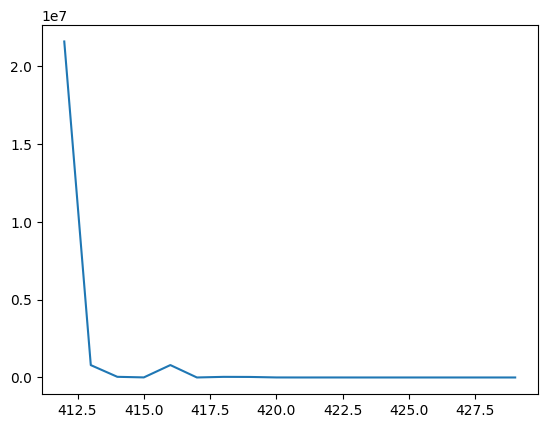

In [180]:
df.query('Symbol=="NIFTY"')['Volume_PE'].plot()

<Axes: >

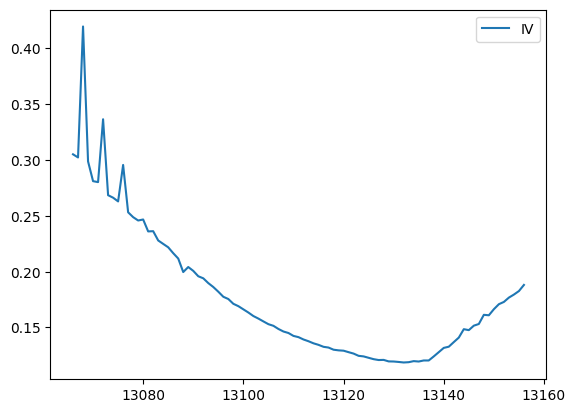

In [14]:
opt_summary.query('Symbol=="NIFTY" and DTE==9')[['IV']].plot()